In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt

cts = ["ICM-1", "ICM-2", "EPI", "PE", "TE-1", "TE-2", "muralTE", "polarTE"]

# Make celltype table

In [2]:
def parse_alleles(x):
    counter = dict()
    if isinstance(x, str):
        for item in x.split(";"):
            k, n = item.split(":")
            n = int(n)
            snp = k[:-2]
            if k[-1] == k[-5]:
                hp = 1
            elif k[-1] == k[-3]:
                hp = 2
            else:
                assert False
            if snp not in counter:
                counter[snp] = [0, 0]
            counter[snp][hp-1] += n
    elif np.isnan(x):
        pass
    else:
        assert False
    return counter

for ct in cts:
    infile = "results/halflife/%s_transcripts.transcript_name.tsv" % ct
    outfile = "results/alleles/%s.tsv" % ct
    if os.path.exists(outfile):
        continue
    d = pd.read_csv(infile, sep="\t", index_col=0)
    rows = []
    for tname, (a1, a2) in zip(d.index, d[["Total.Alleles", "Nascent.Alleles"]].values):
        if "novel" in tname:
            gname = tname.split("novel")[0][:-1]
        else:
            gname = tname[:-4]
        counter1 = parse_alleles(a1)
        counter2 = parse_alleles(a2)
        if len(counter1) > 0:
            snps = counter1.keys()
            for snp in snps:
                total_hp1, total_hp2 = counter1[snp]
                nascent_hp1, nascent_hp2 = 0, 0
                if snp in counter2:
                    nascent_hp1, nascent_hp2 = counter2[snp]
                pval = fisher_exact([[total_hp1 - nascent_hp1, nascent_hp1], [total_hp2 - nascent_hp2, nascent_hp2]])[1]
                rows.append([gname, tname, snp, total_hp1, total_hp2, nascent_hp1, nascent_hp2, pval])
    m = pd.DataFrame(rows)
    m.columns = ["GeneName", "TranscriptName", "Snp", "Total.HP1", "Total.HP2", "Nascent.HP1", "Nascent.HP2", "Pvalue"]
    m["NTR.HP1"] = m["Nascent.HP1"] / m["Total.HP1"]
    m["NTR.HP2"] = m["Nascent.HP2"] / m["Total.HP2"]
    m["Total.Max"] = m[["Total.HP1", "Total.HP2"]].max(axis=1)
    m["Total.Min"] = m[["Total.HP1", "Total.HP2"]].min(axis=1)
    m["Total.All"] = m["Total.HP1"] + m["Total.HP2"]
    m["Total.DiffRatio"] = (m["Total.HP2"] - m["Total.HP1"]) / m["Total.All"]
    m["Proportion.HP1"] = m["Total.HP1"] / m["Total.All"]
    m["Proportion.HP2"] = m["Total.HP2"] / m["Total.All"]
    m["Log2FC"] = np.log2(m["Total.HP2"] / m["Total.HP1"])
    m.to_csv(outfile, sep="\t", index=False)

/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Allele-specific expressed

Maternal: ['Calcoco2' 'Rpsa' 'Rps18' 'Gm15459' 'Rpl29' 'Rps8' 'Atp6v0c' 'Hspa8'
 'Eif4a1' 'Psmb5' 'Rpl31-ps8' 'Cox7a2l' 'Rpl29' 'Trap1a']
Paternal: ['Snrpn' 'Gm13736']
Maternal: ['Rps18' 'Rpsa' 'Rpl29' 'Rps8' 'Calcoco2' 'Gm15459' 'Rpl31-ps8' 'Atp6v0c'
 'Eif4a1' 'Psmb5' 'Hspa8' 'Cox7a2l' 'Gstp2' 'Rpl29' 'Trap1a' 'Gm2000'
 'Tpm3' 'Stmn1' 'Gm9843' 'Spns1' 'Sfr1']
Paternal: ['Snrpn' 'Gm13736' 'Gm14586' 'Snhg1' 'Sfr1' 'Rpl17-ps3' 'Rps18-ps6'
 'Gm3375']
Maternal: ['Rps18' 'Rpsa' 'Rpl29' 'Rps8' 'Gm15459' 'Rpl31-ps8' 'Psmb5' 'Stmn1'
 'Eif4a1' 'Atp6v0c' 'Trap1a' 'Cox7a2l' 'Gstp2' 'Hspa8' 'Tceal9' 'Rpl29'
 'Eno1' 'Tpm3']
Paternal: ['Snrpn']
Maternal: ['Rpsa' 'Rps18' 'Rpl29' 'Gm15459' 'Rps8' 'Rpl31-ps8' 'Stmn1' 'Atp6v0c'
 'Eif4a1' 'Psmb5' 'Cox7a2l' 'Hspa8' 'Npl' 'Tceal9' 'Rpl29']
Paternal: []
Maternal: ['Calcoco2' 'Rpsa' 'Gm15459' 'Rps18' 'Rpl29' 'Atp6v0c' 'Hspa8' 'Rps8'
 'Rpl31-ps8' 'Psmb5' 'Eif4a1' 'Cox7a2l' 'Trap1a']
Paternal: ['Snrpn']
Maternal: ['Rps18' 'Rpsa' 'Calcoco2' 'Rpl29' 'Gm15459' 'R

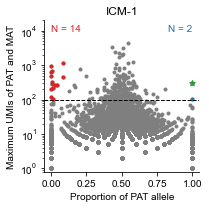

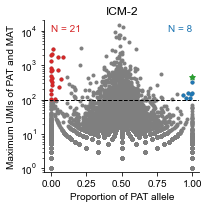

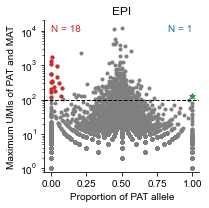

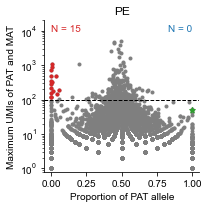

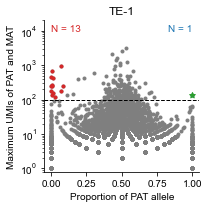

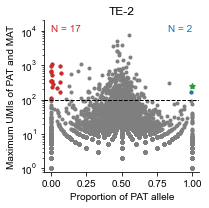

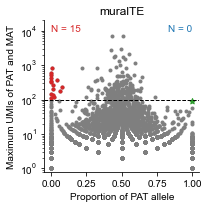

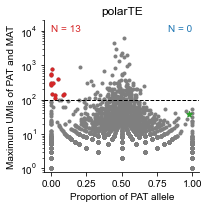

In [3]:
candidates = []
paternals = []
maternals = []
allele_specific_genes = []
for ct in cts:
    m = pd.read_csv("results/alleles/%s.tsv" % ct, sep="\t")
    m = m.sort_values(by="Total.Max", ascending=False)
    m = m[~m["TranscriptName"].duplicated()]
    m1 = m[(m["Total.Max"] >= 100) & (m["Proportion.HP2"] < 0.1)]    
    m2 = m[(m["Total.Max"] >= 100) & (m["Proportion.HP2"] > 0.9)]
    allele_specific_genes.append([m1, m2])
    
    xs, ys = m["Proportion.HP2"], m["Total.All"]
    xs1, ys1 = m1["Proportion.HP2"], m1["Total.All"]
    xs2, ys2 = m2["Proportion.HP2"], m2["Total.All"]
    print("Maternal:", m1["GeneName"].values)
    print("Paternal:", m2["GeneName"].values)
    candidates.extend(m1["TranscriptName"].values)
    candidates.extend(m2["TranscriptName"].values)
    paternals.extend(m2["TranscriptName"].values)
    maternals.extend(m1["TranscriptName"].values)
    
    m3 = m[m["GeneName"] == "Snrpn"].head(1)
    xs3, ys3 = m3["Proportion.HP2"], m3["Total.All"]

    plt.figure(figsize=(3, 3))
    plt.title(ct)
    plt.scatter(xs, ys, marker=".", color="C7")
    plt.scatter(xs1, ys1, marker=".", color="C3")
    plt.scatter(xs2, ys2, marker=".", color="C0")
    plt.scatter(xs3, ys3, marker="*", color="C2", label="Snrpn")
    plt.axhline(100, lw=1, ls="--", color="black")
    plt.xlabel("Proportion of PAT allele")
    plt.ylabel("Maximum UMIs of PAT and MAT")
    plt.yscale("log")
    plt.ylim(0.8, 20000)
    plt.text(0, 10000, "N = %d" % len(m1), color="C3")
    plt.text(1, 10000, "N = %d" % len(m2), color="C0", ha="right")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/allele_expression.%s.pdf" % ct, dpi=300)
    # break

In [4]:
print(list(sorted(set(candidates))))

['Atp6v0c-201', 'Calcoco2-201', 'Cox7a2l-201', 'Eif4a1-213', 'Eno1-202', 'Gm13736-201', 'Gm14586-201', 'Gm15459-201', 'Gm2000-201', 'Gm3375-201', 'Gm9843-201', 'Gstp2-201', 'Hspa8-201', 'Npl-201', 'Psmb5-201', 'Rpl17-ps3-201', 'Rpl29-201', 'Rpl29-203', 'Rpl31-ps8-201', 'Rps18-201', 'Rps18-ps6-201', 'Rps8-201', 'Rpsa-201', 'Sfr1-201', 'Sfr1.novel.56991', 'Snhg1.novel.54748', 'Snrpn-201', 'Sord-201', 'Spns1-201', 'Stmn1-201', 'Tceal9-201', 'Tpm3-201', 'Trap1a-201']


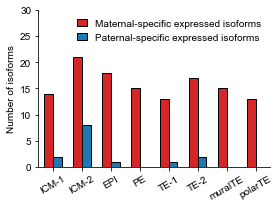

In [5]:
ys1 = [len(item[0]) for item in allele_specific_genes]
ys2 = [len(item[1]) for item in allele_specific_genes]
xs = np.arange(len(ys1))
w = 0.3
plt.figure(figsize=(4, 3))
plt.bar(xs - w / 2, ys1, width=w, edgecolor="black", color="C3", label="Maternal-specific expressed isoforms")
plt.bar(xs + w / 2, ys2, width=w, edgecolor="black", color="C0", label="Paternal-specific expressed isoforms")
plt.legend(handlelength=1, frameon=False)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 30)
plt.xticks(xs, cts, rotation=30)
plt.ylabel("Number of isoforms")
for loc in ["top", "right"]:
    plt.gca().spines[loc].set_visible(False)
plt.tight_layout()
plt.savefig("figures/number_of_allele_specific_isoforms.pdf", dpi=300)

In [6]:
data = dict()
for ct in cts:
    m = pd.read_csv("results/alleles/%s.tsv" % ct, sep="\t")
    m["TPM.HP1"] = m["Total.HP1"] * 1e6 / m["Total.All"].sum()
    m["TPM.HP2"] = m["Total.HP2"] * 1e6 / m["Total.All"].sum()
    m = m.sort_values(by="Total.Max", ascending=False)
    m = m[~m["TranscriptName"].duplicated()]
    data[ct] = m

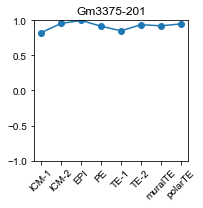

[0.825      0.95614035 1.         0.91666667 0.85185185 0.93846154
 0.92307692 0.95      ]
[ 40 114  49  24  27  65  26  20]
[7 5 0 2 4 4 2 1]
[ 33 109  49  22  23  61  24  19]


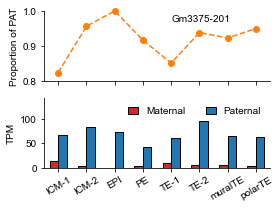

In [7]:
candidates = set(candidates)
for tname in candidates:
    if tname != "Gm3375-201":
        continue
        
    array = []
    for ct in cts:
        m = data[ct]
        tmp = m[m["TranscriptName"] == tname].copy()
        tmp["CellType"] = ct
        array.append(tmp)
    d = pd.concat(array, axis=0, ignore_index=True)
    d.index = d["CellType"]
    # print(tname)
    
    ys = d["Proportion.HP2"]
    if all(ys > 0.9) or all(ys < 0.1):
        continue
    
    plt.figure(figsize=(3, 3))
    plt.title(tname)
    plt.plot(ys, marker="o")
    plt.xticks(rotation=45)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()
    plt.close()
    print(d["Proportion.HP2"].values)
    print(d["Total.All"].values)
    print(d["Total.HP1"].values)
    print(d["Total.HP2"].values)
    
    fig, axs = plt.subplots(2, 1, figsize=(4, 3), sharex=True)    
    plt.sca(axs[0])
    plt.plot(xs, ys, marker="o", ls="--", color="C1", clip_on=False)
    plt.ylim(0.8, 1)
    plt.ylabel("Proportion of PAT")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.text(4, 0.97, tname)
    
    plt.sca(axs[1])
    w = 0.3
    ys1 = d["TPM.HP1"]
    ys2 = d["TPM.HP2"]
    ymax = max(max(ys1), max(ys2))
    plt.bar(xs - w/2, ys1, width=w, edgecolor="black", color="C3", label="Maternal")
    plt.bar(xs + w/2, ys2, width=w, edgecolor="black", color="C0", label="Paternal")
    plt.ylim(0, ymax * 1.5)
    plt.ylabel("TPM")
    plt.xticks(xs, cts, rotation=30)
    plt.legend(handlelength=1, frameon=False, ncol=2)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
    
    plt.tight_layout()
    plt.savefig("figures/allele_specific_expressed_change.%s.pdf" % tname, dpi=300)
    # break

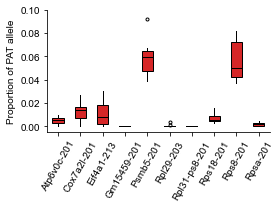

In [8]:
maternals = list(sorted(set(maternals)))
array = []
ticks = []
for tname in maternals:
    array1 = []
    for ct in cts:
        tmp = data[ct]
        tmp = tmp[tmp["TranscriptName"] == tname]
        array1.append(tmp)
    tmp = pd.concat(array1, ignore_index=True)
    if tmp["Total.Max"].min() >= 100:
        array.append(tmp["Proportion.HP2"])
        ticks.append(tname)
xs = np.arange(len(array))
plt.figure(figsize=(4, 3))
plt.boxplot(array, positions=xs, 
            medianprops=dict(color="black"),
            showcaps=False,
            patch_artist=True,
            boxprops=dict(facecolor="C3"),
            flierprops=dict(marker="."))
plt.xticks(xs, ticks, rotation=60)
plt.ylim(0 - 0.005, 0.1)
plt.ylabel("Proportion of PAT allele")
for loc in ["top", "right"]:
    plt.gca().spines[loc].set_visible(False)
plt.tight_layout()
plt.savefig("figures/paternal_bias_of_maternal_isoforms.pdf", dpi=300)

# Correlation of NTR

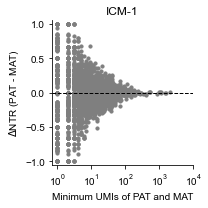

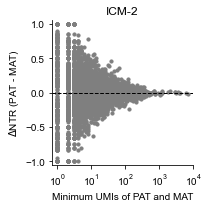

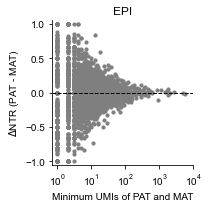

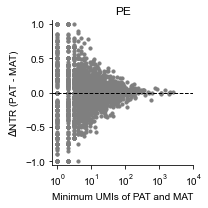

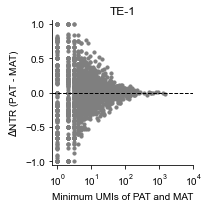

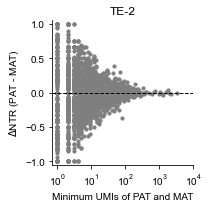

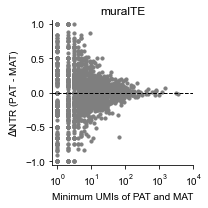

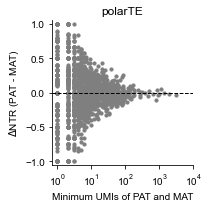

In [9]:
for ct in cts:
    m = pd.read_csv("results/alleles/%s.tsv" % ct, sep="\t")
    m["NTR.Diff"] = m["NTR.HP2"] - m["NTR.HP1"]
    m = m[m["Total.Min"] > 0]
    m = m.sort_values(by="Total.All", ascending=False)
    m = m[~m["TranscriptName"].duplicated()]
    m1 = m[(m["Total.Min"] >= 10) & (m["Pvalue"] < 0.05) & (m["NTR.HP1"] - m["NTR.HP2"] < -0.1)]
    m2 = m[(m["Total.Min"] >= 10) & (m["Pvalue"] < 0.05) & (m["NTR.HP1"] - m["NTR.HP2"] > 0.1)]
    xs, ys = m["Total.Min"], m["NTR.Diff"]
    xs1, ys1 = m1["Total.Min"], m1["NTR.Diff"]
    xs2, ys2 = m2["Total.Min"], m2["NTR.Diff"]

    plt.figure(figsize=(3, 3))
    plt.title(ct)
    s = 10
    plt.scatter(xs, ys, marker="o", s=s, color="C7", clip_on=False)
    plt.axhline(0, ls="--", lw=1, color="black")
    if False:
        plt.scatter(xs1, ys1, marker="o", s=s, color="C3", clip_on=False)
        plt.scatter(xs2, ys2, marker="o", s=s, color="C0", clip_on=False)
        plt.text(1000, 0.8, "N = %d" % len(m1), color="C3")
        plt.text(1000, -0.8, "N = %d" % len(m2), color="C0")
    plt.xscale("log")
    plt.xlim(0.7, 10000)
    plt.xticks([1, 10, 100, 1000, 10000])
    plt.ylim(-1.05, 1.05)
    plt.xlabel("Minimum UMIs of PAT and MAT")
    plt.ylabel("$\Delta$NTR (PAT - MAT)")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/allele_ntr_diff.%s.pdf" % ct, dpi=300)
    # break

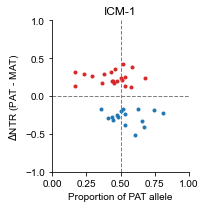

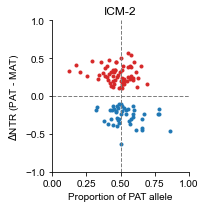

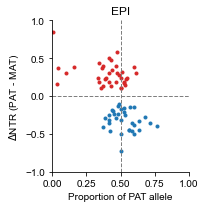

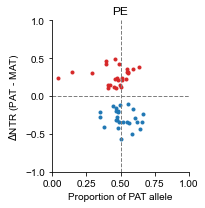

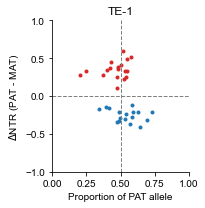

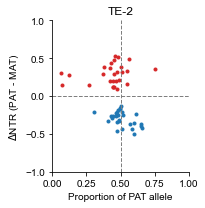

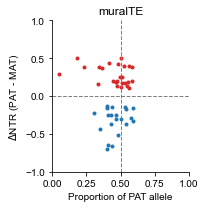

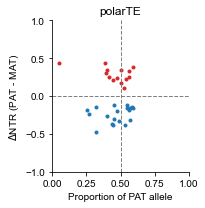

In [10]:
for ct in cts:
    m = pd.read_csv("results/alleles/%s.tsv" % ct, sep="\t")
    m["NTR.Diff"] = m["NTR.HP2"] - m["NTR.HP1"]
    m = m[m["Total.Min"] > 0]
    m = m.sort_values(by="Total.All", ascending=False)
    m = m[~m["TranscriptName"].duplicated()]
    m1 = m[(m["Total.Min"] >= 10) & (m["Pvalue"] < 0.05) & (m["NTR.HP1"] - m["NTR.HP2"] < -0.1)]
    m2 = m[(m["Total.Min"] >= 10) & (m["Pvalue"] < 0.05) & (m["NTR.HP1"] - m["NTR.HP2"] > 0.1)]
    
    xs1, ys1 = m1["Proportion.HP2"], m1["NTR.Diff"]
    xs2, ys2 = m2["Proportion.HP2"], m2["NTR.Diff"]
    plt.figure(figsize=(3, 3))
    plt.title(ct)
    plt.scatter(xs1, ys1, color="C3", marker=".")
    plt.scatter(xs2, ys2, color="C0", marker=".")
    plt.axhline(0, lw=1, ls="--", color="C7")
    plt.axvline(0.5, lw=1, ls="--", color="C7")
    plt.xlim(0, 1)
    plt.ylim(-1, 1)
    plt.xlabel("Proportion of PAT allele")
    plt.ylabel("$\Delta$NTR (PAT - MAT)")
    for loc in ["top", "right"]:
        plt.gca().spines[loc].set_visible(False)
    plt.tight_layout()
    plt.show()    
    # break

# Change of NTR

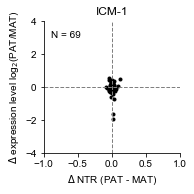

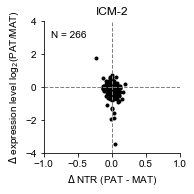

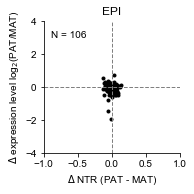

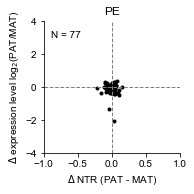

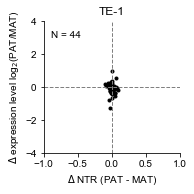

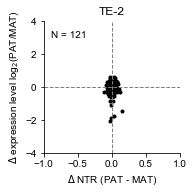

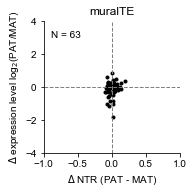

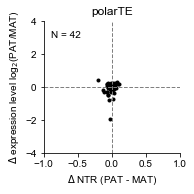

In [11]:
for ct in cts:
    m = pd.read_csv("results/alleles/%s.tsv" % ct, sep="\t")
    m = m.sort_values(by="Total.Max", ascending=False)
    m = m[m["Total.Min"] > 100]
    m = m.sort_values(by="Log2FC")
    m = m[~m["TranscriptName"].duplicated()]

    xs = m["NTR.HP2"] - m["NTR.HP1"]
    ys = np.log2(m["Total.HP2"]/m["Total.HP1"])

    plt.figure(figsize=(2.8, 2.8))
    plt.title(ct)
    plt.scatter(xs, ys, marker=".", color="black", clip_on=False)
    #plt.plot([0, 1], [0, 1], lw=1, ls="--", color="C7")
    plt.axvline(0, ls="--", lw=1, color="grey")
    plt.axhline(0, ls="--", lw=1, color="grey")
    plt.text(-0.9, 3, "N = %d" % len(m))
    # plt.text(0.1, 0.8, "r = %.2f" % r)
    plt.xlim(-1, 1)
    plt.ylim(-4, 4)
    plt.xlabel("$\Delta$ NTR (PAT - MAT)")
    plt.ylabel("$\Delta$ expression level log$_2$(PAT/MAT)")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/allele_ntr_expression.%s.pdf" % ct, dpi=300)

ICM-1
ICM-2
EPI
PE
TE-1
TE-2
muralTE
polarTE


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


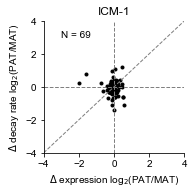

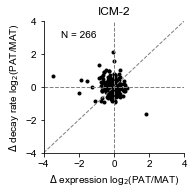

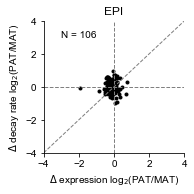

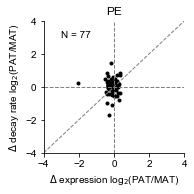

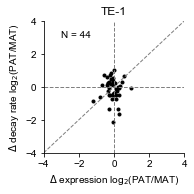

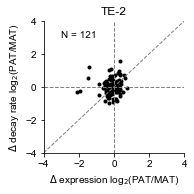

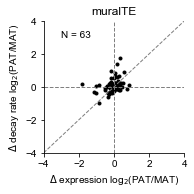

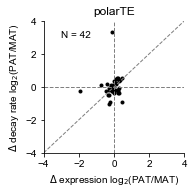

In [12]:
for ct in cts:
    print(ct)
    
    m = pd.read_csv("results/alleles/%s.tsv" % ct, sep="\t")
    m = m.sort_values(by="Total.Max", ascending=False)
    m = m[m["Total.Min"] > 100]
    m = m[~m["TranscriptName"].duplicated()]
    m["T.HP1"] = -3 / np.log2(1 - m["NTR.HP1"])
    m["T.HP2"] = -3 / np.log2(1 - m["NTR.HP2"])
    m["K.HP1"] = m["Total.HP1"] * np.log(2) / m["T.HP1"]
    m["K.HP2"] = m["Total.HP2"] * np.log(2) / m["T.HP2"]
    m["D.HP1"] = np.log(2) / m["T.HP1"]
    m["D.HP2"] = np.log(2) / m["T.HP2"]
    
    xs = np.log2(m["Total.HP2"]/m["Total.HP1"])
    ys = np.log2(m["D.HP2"]/m["D.HP1"])
    #r = np.corrcoef(xs, ys)[0][1]

    plt.figure(figsize=(2.8, 2.8))
    plt.title(ct)
    plt.scatter(xs, ys, marker=".", color="black", clip_on=False)
    plt.plot([-4, 4], [-4, 4], lw=1, ls="--", color="C7")
    plt.axvline(0, ls="--", lw=1, color="grey")
    plt.axhline(0, ls="--", lw=1, color="grey")
    plt.text(-3, 3, "N = %d" % len(m))
    #plt.text(-3, 2, "r = %.2f" % r)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.ylabel("$\Delta$ decay rate log$_2$(PAT/MAT)")
    plt.xlabel("$\Delta$ expression log$_2$(PAT/MAT)")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/allele_decay_expression.%s.pdf" % ct, dpi=300)    
    # break

In [13]:
for ct in cts:
    m = pd.read_csv("results/alleles/%s.tsv" % ct, sep="\t")
    m = m.sort_values(by="Total.All", ascending=False)
    m = m[m["Total.Max"] > 50]
    m = m[~m["TranscriptName"].duplicated()]
    
    for gene, tmp in m.groupby(by="GeneName"):
        if len(tmp) > 1:
            # print(gene, len(tmp))
            vs = tmp["Total.DiffRatio"].values
            v = abs(vs[1] - vs[0])
            if v > 0.8:
                print("-" * 80)
                print(ct, v, vs)
                print(tmp["TranscriptName"])

--------------------------------------------------------------------------------
ICM-2 1.5524475524475525 [ 0.55244755 -1.        ]
60160    Coil.novel.19151
60167    Coil.novel.19153
Name: TranscriptName, dtype: object
--------------------------------------------------------------------------------
ICM-2 0.8197541036465052 [-0.03744118  0.78231293]
19276             Dppa5a-201
57733    Dppa5a.novel.111864
Name: TranscriptName, dtype: object
--------------------------------------------------------------------------------
ICM-2 1.2108433734939759 [ 0.21084337 -1.        ]
5410     Mrpl11-201
55488    Mrpl11-204
Name: TranscriptName, dtype: object
--------------------------------------------------------------------------------
ICM-2 0.8888888888888888 [-0.11111111 -1.        ]
13942    Mrpl55-201
26289    Mrpl55-203
Name: TranscriptName, dtype: object
--------------------------------------------------------------------------------
ICM-2 1.9275631756524134 [ 0.9858156  -0.94174757]
67793 